# Design methodology and SLS deflection limit according to EC2 / Modelcode

In [ ]:
%matplotlib widget
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from cymbol import Cymbol

In [ ]:
import sympy as sp
sp.init_printing()

## Recap of the EC2 commentary - German

### Assumptions according to Eurocode 2 Commentary (Rev A 31-03-2017)

* **Beanspruchungen:**
 * Die Beanspruchungsverhältnisse aus ständigen und veränderlichen Lasten werden vorgegeben. damit eine Bemessung im GZT einschließlich der Ermittlung der erforderlichen Biegezugbewehrung erfolgen kann.
 * $q_\mathrm{k,tot}$ ist die gesamte charakteristische Last und besteht aus den folgenden ständigen und veränderlichen Lasten.
   * Ständige Lasten:\
     $g_k  = 45\% q_\mathrm{k,tot}$ 	(Eigenlast)\
     $Δg_k  = 30\% q_\mathrm{k,tot}$	(Ausbaulast)
   * Nutzlast (veränderliche Last):\
     $q_k  = 25\% q_\mathrm{k,tot}$
     
 * Bemessungslast im GZT (Grenzzustand der Tragfähigkeit):
 
   $q_\mathrm{GZT}=\gamma_G  \cdot (g + Δg_k )+\gamma_Q  \cdot q_k$
   $q_\mathrm{GZT}= 1.35 \cdot (0.45 q_\mathrm{k,tot}  + 0.3 q_\mathrm{k,tot} )+ 1.5 \cdot 0.25 q_\mathrm{k,tot}  = 1.39 q_\mathrm{k,tot}$
   
   dabei sind $\gamma_G$ und $\gamma_Q$ Teilsicherheitsbeiwerte für ständige und veränderliche Lasten.

 * Quasi-ständige Last im GZG,qs (Grenzzustand der Gebrauchstauglichkeit):
 
   $q_\mathrm{GZG,qs}=g + Δg_k + ψ_2 \cdot q_k$\
   $q_\mathrm{GZG,qs}=0.45 q_\mathrm{k,~tot}  + 0.3 q_\mathrm{k,~tot}  + 0.3 \cdot 0.25 q_\mathrm{k,~tot}  = 0.825 q_\mathrm{k,~tot}$
   
   dabei ist $ψ_2$ der Kombinationsbeiwert für die veränderliche Last.
   
	Verhältnis $q_\mathrm{GZG,qs}/q_\mathrm{GZT} =(0.825 q_\mathrm{k,~tot})/(1.39 q_\mathrm{k,~tot}) =0.59$


* **Teilsicherheitsbeiwerte und Materialeigenschaften:**
 * Materialsicherheitsbeiwerte:
   * Betonstahl: $\gamma_\mathrm{s} = 1.15$
   * Carbon: $\gamma_\mathrm{Carbon} = 1.5$
   * Beton: $\gamma_\mathrm{c}/α = 1.5/0.85$
 * Streckgrenze der Betonstahlbewehrung: 500 N/mm2
 * Betondruckfestigkeit: 30 N/mm2

## Symbolic implementation of the load model

**SLS Loading**

The loading model including permanent and variable loads is considered with the goal to mimic the SLS design. Let us assume the characteristic load combination $p_\mathrm{Ek}$ relevant for the servieability limit state consists of three load cases 
 $$
 p_\mathrm{Ek} = g_\mathrm{Ek} + \Delta g_\mathrm{Ek} + q_\mathrm{Ek},
 $$

In [ ]:
p_Ek = Cymbol(r'p_\mathrm{Ek}', codename='p_Ek')

The load combination in SLS state consists of
* permanent loads
   - $g_\mathrm{Ek} = \varphi_g \, p_\mathrm{Ek}$	(selfweight)
   - $\Delta g_\mathrm{Ek} = \varphi_{\Delta g}\, p_\mathrm{Ek}$	(deadweight)
 * service loads
   * $q_\mathrm{Ek} = (1 - \varphi_g - \varphi_{\Delta g}) \, p_\mathrm{Ek}$	(variable load).

In [ ]:
psi_2 = Cymbol(r'\psi_2', codename='psi_2')
phi_g = Cymbol(r'\varphi_g', codename='phi_g')
phi_delta_g = Cymbol(r'\varphi_{\Delta g}', codename='phi_delta_g')
phi_g, phi_delta_g

In [ ]:
g_Ek = phi_g * p_Ek
delta_g_Ek = phi_delta_g * p_Ek
q_Ek = (1 - phi_g - phi_delta_g) * p_Ek

The quasi-permament loads in SLS taking into account the frequency of occurrence of the variable loads via the combination coefficient $\psi_2$ are given as
$$
p_\mathrm{Ek,qp} = g_\mathrm{Ek} + \Delta g_\mathrm{Ek} + \psi_2 \, q_\mathrm{Ek}
$$

In [ ]:
p_Ek_qp = g_Ek + delta_g_Ek + psi_2 * q_Ek
p_Ek_qp

In [ ]:
zeta_p_Ek = sp.simplify(p_Ek_qp) / p_Ek
zeta_p_Ek

In [ ]:
get_zeta_p_Ek = sp.lambdify((phi_g, phi_delta_g, psi_2), zeta_p_Ek) 

In [ ]:
zeta_p_Ek_qp_ = get_zeta_p_Ek( phi_g=0.36, phi_delta_g=0.24, psi_2=0.3)
zeta_p_Ek_qp_

**ULS loading**

In [ ]:
gamma_G = Cymbol(r'\gamma_\mathrm{G}', codename='gamma_G')
gamma_Q = Cymbol(r'\gamma_\mathrm{Q}', codename='gamma_Q')

In [ ]:
p_Ed_u = gamma_G * (g_Ek + delta_g_Ek) + gamma_Q * q_Ek
p_Ed_u

In [ ]:
zeta_p_Ed_u = sp.simplify(p_Ed_u / p_Ek)
get_zeta_p_Ed_u = sp.lambdify((phi_g, phi_delta_g, gamma_G, gamma_Q), zeta_p_Ed_u)
zeta_p_Ed_u

In [ ]:
zeta_p_Ed_u_ = get_zeta_p_Ed_u(phi_g=0.36, phi_delta_g=0.24, gamma_G=1.35, gamma_Q=1.5)

The ratios of ultimate and service load levels with respect to the characteristic load level $p_\mathrm{Ek}$ have the values 

In [ ]:
zeta_p_Ed_u_, zeta_p_Ek_qp_

Finally the constraint coupling the level of SLS quasi-permanent and ULS load reads
$$
 p_\mathrm{Ek,qp} = \frac{\zeta_{\mathrm{p,Ek,qp}}}{\zeta_{\mathrm{p,Ed,u}}} 
 p_\mathrm{Ed,u}
 = 
 0.51 p_\mathrm{Ed,u}
$$
as quantified below

In [ ]:
zeta_p_Ek_qp_ / zeta_p_Ed_u_

## Definition of utilization with respect to $w_\mathrm{limit}$

With known load deflection curve $F(w)$, it is possible to evaluate the relation between the serviceability load obtained form the load combination model which is directly coupled to the ultimate limit load on the one hand, and the load level corresponding to the maximum allowable deflection obtained as
$$
  w_\mathrm{limit} = \chi L,
$$
with $\chi$ set according to the usability requirement, i.e. $\chi = 1/250$. With $F_\mathrm{limit} = F(w_\mathrm{limit})$, we can introduce
$$
 \eta_\mathrm{qs} = \frac{F_\mathrm{limit}}{p_\mathrm{Ek,qs}}
$$

**CONTINUE HERE XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX**

## Relation between ($q_\mathrm{SLS}, q_\mathrm{ULS}, q_\mathrm{tot}$) or, new notation ($q_\mathrm{Rk}, q_\mathrm{Rd}, q_\mathrm{Ed,ULS}, q_\mathrm{Ek(tot)}, q_\mathrm{Ed,SLS(quasi-permanent)}$)

In [ ]:
# CFRP Load-deflection curve example data
w = np.array([0, 1, 5, 7, 10, 50])
q = np.array([0, 10, 11, 12, 15, 70])

L = 7500

In [ ]:
fig, ax = plt.subplots() # figsize = (10, 5)
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# ax.legend()
ax.set_xlabel('w [mm]')
ax.set_ylabel('q [kN/m]')

ax.plot(w, q, c= 'k')
# ax.axhline(y=current_F, color='r')
# ax.annotate(r'$F_{\mathrm{tot,~max}} = $', xy=(0, 1.02 * current_F), color='r')

# w_limit:
ax.axhline(y=L/250, color='r', ls='--', lw=1)
ax.annotate('$L/250$', xy=(L/250, 70), color='r')

# w_limit:
ax.axvline(x=L/250, color='r', ls='--', lw=1)
ax.annotate('$L/250$', xy=(L/250, 70), color='r')

### Slenderness lines are derived by setting $(q_\mathrm{limit} - 0.59 \cdot q_\mathrm{ULS} = 0)$

## Thoughts about relating utilization factor to deflection limit

* F_limit/F_Ed,SLS,LM = utilization factor

* F_limit/F_Rd = utilization factor

* F_limit/F_Rk = utilization factor

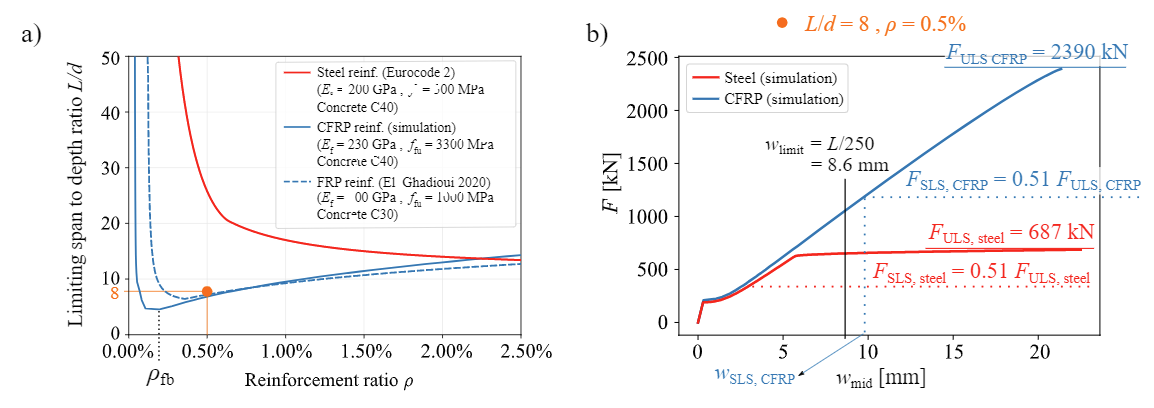

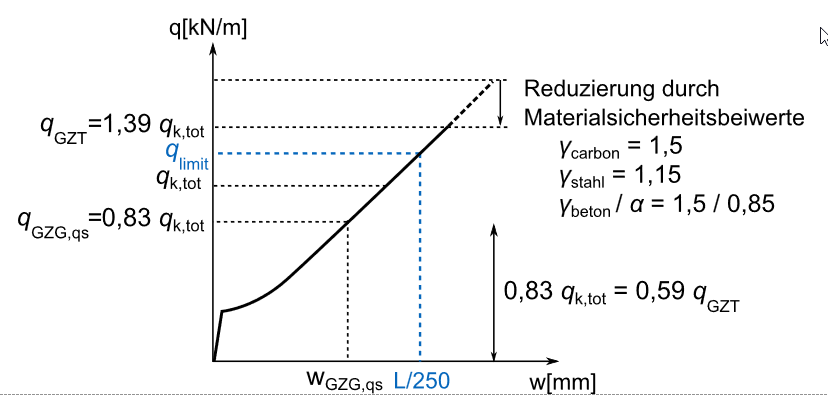

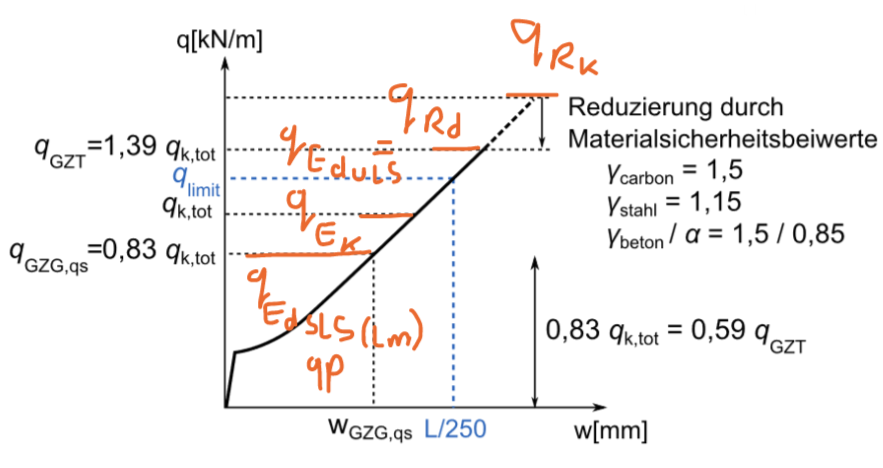

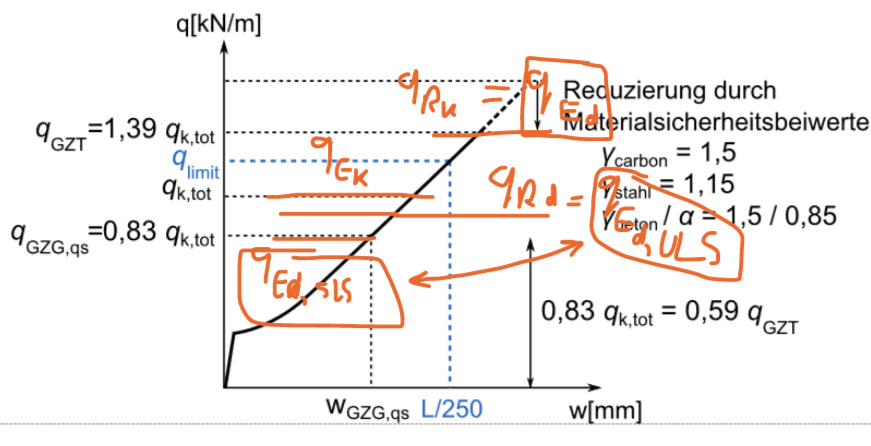

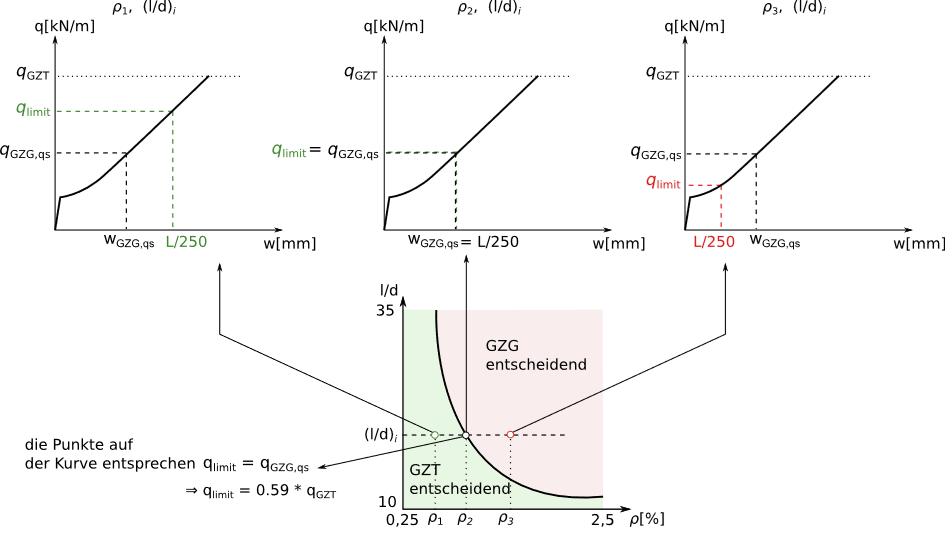

### Extract from EC2 commentary
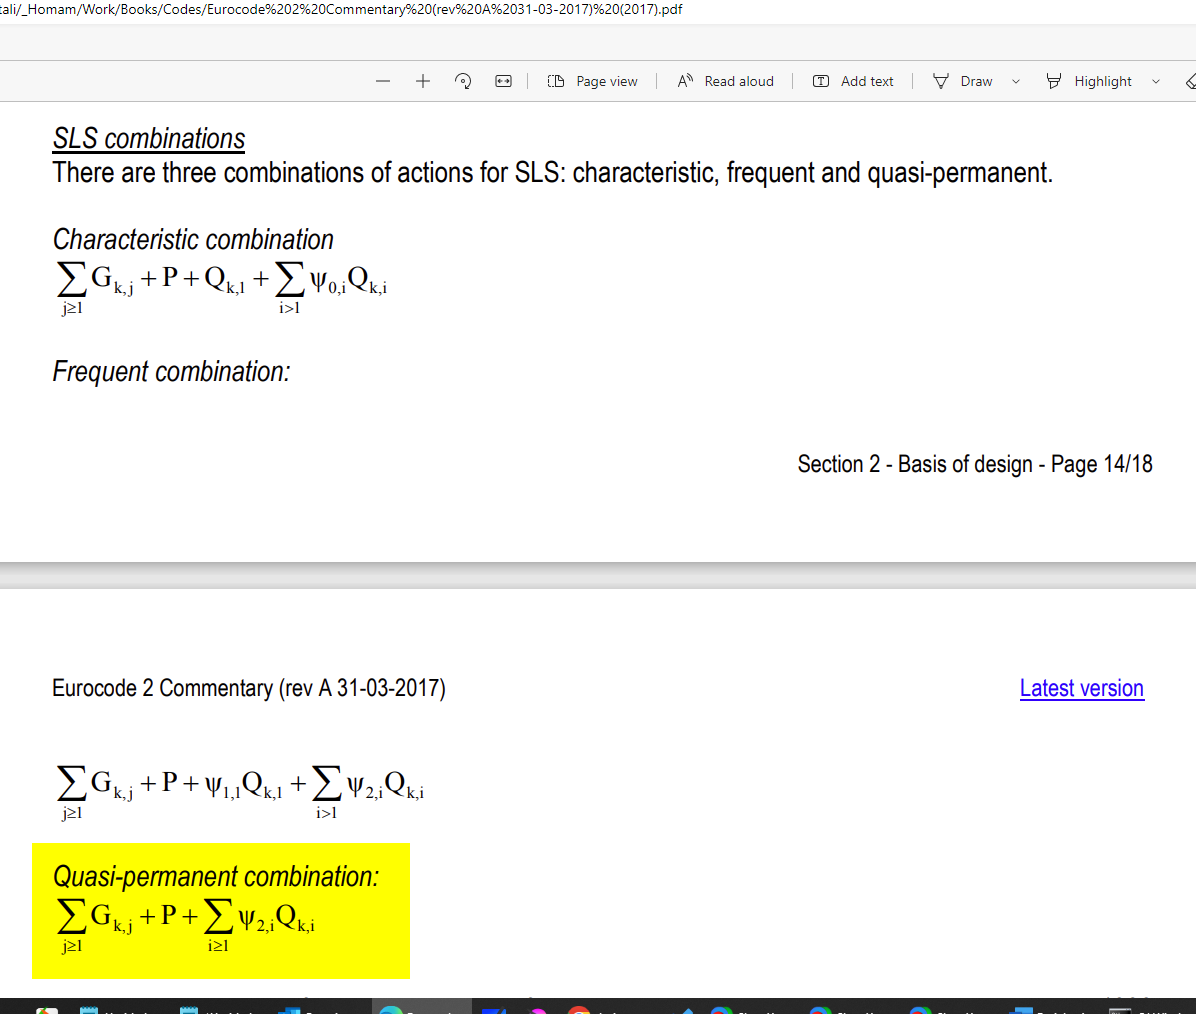